In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import joblib
import requests, zipfile, io
import nltk
from sklearn.metrics import precision_recall_fscore_support

In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
url = "https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip"
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [4]:
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='ISO-8859-1', header=None)
df.columns = ['polarity', 'id', 'date', 'query', 'user', 'text']

In [5]:
df['sentiment'] = df['polarity'].apply(lambda x: 'positive' if x == 4 else 'negative' if x == 0 else 'neutral')
df = df[df['sentiment'] != 'neutral']

In [6]:
def clean_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = text.lower()
    return text


In [7]:
df['cleaned_text'] = df['text'].apply(clean_text)


In [8]:
df['tokens'] = df['cleaned_text'].apply(word_tokenize)

In [9]:
stop_words = set(stopwords.words('english'))
df['tokens'] = df['tokens'].apply(lambda x: [word for word in x if word not in stop_words])

In [10]:
stemmer = PorterStemmer()
df['tokens'] = df['tokens'].apply(lambda x: [stemmer.stem(word) for word in x])

In [11]:
df['processed_text'] = df['tokens'].apply(lambda x: ' '.join(x))

In [12]:
X = df['processed_text']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
vectorizer = TfidfVectorizer(max_features=5000)  # Limit to 5000 features
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


In [14]:
model = LogisticRegression()
model.fit(X_train_vec, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [15]:
y_pred = model.predict(X_test_vec)

In [16]:
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))


Accuracy: 0.771253125
              precision    recall  f1-score   support

    negative       0.78      0.75      0.77    159494
    positive       0.76      0.79      0.78    160506

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



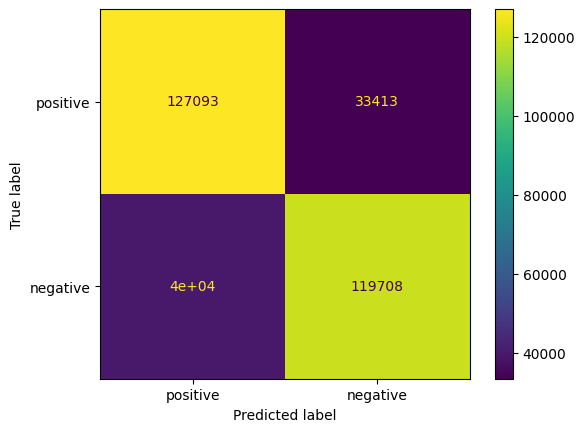

In [17]:
cm = confusion_matrix(y_test, y_pred, labels=['positive', 'negative'])
ConfusionMatrixDisplay(cm, display_labels=['positive', 'negative']).plot()


In [25]:
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

In [26]:
metrics = pd.DataFrame({'Metric': ['Precision', 'Recall', 'F1-Score', 'Accuracy'],
                        'Score': [precision, recall, f1, accuracy_score(y_test, y_pred)]})

<ipython-input-31-5ea8463c2818>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Metric', y='Score', data=metrics, palette='pastel')


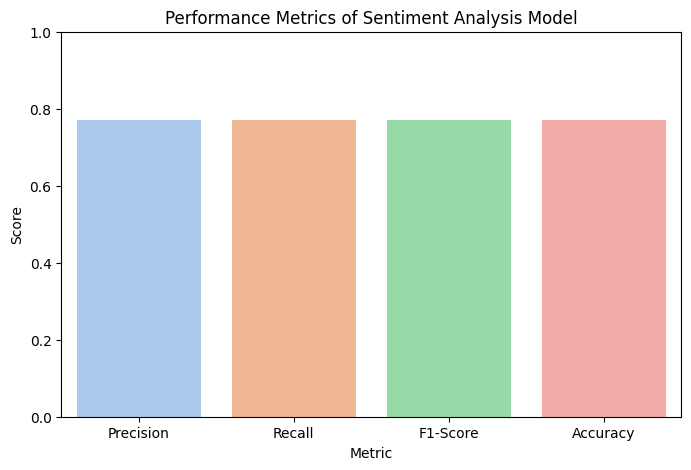

In [31]:
plt.figure(figsize=(8, 5))
sns.barplot(x='Metric', y='Score', data=metrics, palette='pastel')
plt.title('Performance Metrics of Sentiment Analysis Model')
plt.ylim(0, 1.0)
plt.show()

In [18]:
joblib.dump(model, 'sentiment_model.pkl')

['sentiment_model.pkl']

In [19]:
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

In [20]:
loaded_model = joblib.load('sentiment_model.pkl')
loaded_vectorizer = joblib.load('tfidf_vectorizer.pkl')

In [21]:
def predict_sentiment(text):
    processed_text = clean_text(text)
    processed_tokens = word_tokenize(processed_text)
    processed_tokens = [word for word in processed_tokens if word not in stop_words]
    processed_tokens = [stemmer.stem(word) for word in processed_tokens]
    final_text = ' '.join(processed_tokens)
    vectorized_text = loaded_vectorizer.transform([final_text])
    prediction = loaded_model.predict(vectorized_text)
    return prediction[0]

In [22]:
example_text = input("Enter a reveiw : ")
print(f"Sentiment for '{example_text}': {predict_sentiment(example_text)}")

Enter a reveiw : I dont like it
Sentiment for 'I dont like it': negative
